<a href="https://colab.research.google.com/github/Mahreen11/sales_forecast/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




In [78]:
store_sales = pd.read_csv('train1.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Check for null values if there are any 

In [79]:
store_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [80]:
store_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [81]:
store_sales = store_sales.drop(['store','item'],axis = 1)

In [82]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [83]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

//converting date to object data type to date time data type

In [84]:
store_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting date to month period and then sum the number of items in each month

In [85]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

converting date column to timestamp datatype

In [86]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [87]:
monthly_sales['date'].head(10)

0   2013-01-01
1   2013-02-01
2   2013-03-01
3   2013-04-01
4   2013-05-01
5   2013-06-01
6   2013-07-01
7   2013-08-01
8   2013-09-01
9   2013-10-01
Name: date, dtype: datetime64[ns]

In [88]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


visualize monthly sales of item

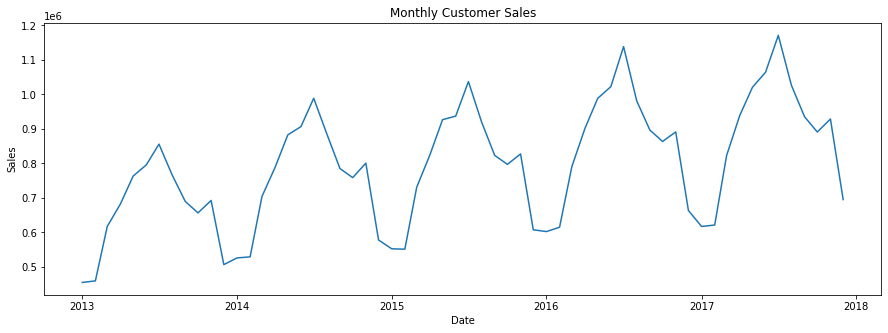

In [89]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

//make a sales difference column to make the sales stationary 

In [90]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)


,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [91]:
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


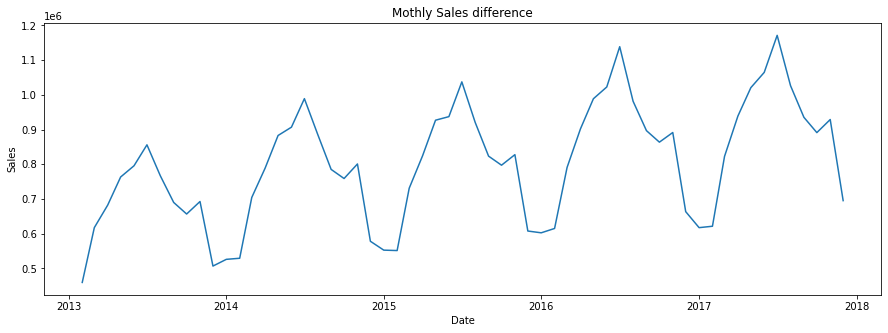

In [92]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Mothly Sales difference")
plt.show()

Dopping of sales and date

In [93]:
supervised_sales = monthly_sales.drop(['date','sales'],axis=1)

preparing the supervised date

In [94]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_sales[col_name] = supervised_sales['sales_diff'].shift(i)
supervised_sales = supervised_sales.dropna().reset_index(drop=True)
supervised_sales.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


split the data into train and test

In [95]:
train_data = supervised_sales[:-12]
test_data = supervised_sales[-12:]
print("Train data ",train_data.shape)
print("Test data ",test_data.shape)


Train data  (35, 13)
Test data  (12, 13)


In [96]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [97]:
x_train,y_train = train_data[:,1:],train_data[:,0:1]
x_test,y_test = test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape ", x_train.shape)
print("y_train shape ", y_train.shape)
print("x_test shape ", x_test.shape)
print("x_test shape ",y_test.shape)

x_train shape  (35, 12)
y_train shape  (35,)
x_test shape  (12, 12)
x_test shape  (12,)


# make prediction data frame to merge predicted sale prices of all trained algorithm

In [98]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales_dates)

In [99]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


create the linear regression model and predicited outputs

In [100]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)


In [101]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [102]:
result_list = []
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series,left_index =True,right_index=True)


In [103]:
print(predict_df)


         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [105]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print("LINEAR REGRESSION MSE ",lr_mse)
print("LINEAR REGRESSION MAE ",lr_mae)
print("LINEAR REGRESSION R2 ",lr_r2)

LINEAR REGRESSION MSE  16221.272385416898
LINEAR REGRESSION MAE  263129677.80188882
LINEAR REGRESSION R2  0.9906152516380968


visualization of prediction against actual sales

<function matplotlib.pyplot.show(*args, **kw)>

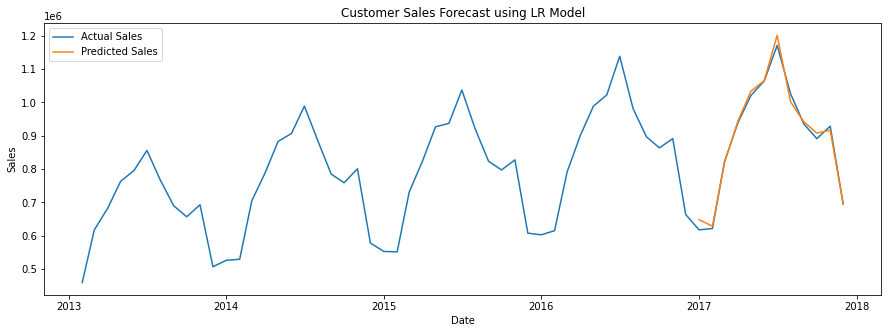

In [106]:

plt.figure(figsize=(15,5))
#Actual Sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#Predicted Sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast using LR Model")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show